In [1]:
from tqdm.notebook import tqdm

In [3]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table
import astropy.units as u

# Dlnpyutils
# from dlnpyutils import utils
from dlnpyutils.utils import bspline,mad

# dust_extinction
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

class Astrologium():
    '''
    A class to calculate a star's extinction, age and mass using PARSEC isochrones with 
    Gaia (E)DR3 and 2MASS photometry.
    '''
    def __init__(self,teff,abund,obsphot,distance,isochrones,ext_law='CCM89',rv=3.1):
        
        '''
        Inputs:
        ------
            teff:       2x1 array-like
                        Teff and error of star np.array([teff,teff_err])
                    
            abund:      2x1 array-like
                        first column is [M/H] and [Alpha/M] and the second column is the errors
                    
            obs_phot:   6x2 array-like
                        first column is BP, G, RP, J, H, and K and the second column is the errors
                        
            distance:   float
                        distance to star in pc
                    
            isochrones: astropy Table 
                        PARSEC isochrone table
                        
            ext_law:    string, optional
                        extinction law to use. Default is CCM89.
                        
                        Available Extinction Laws: 
                        -------------------------
                        
                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022
                        
            rv:         float, optional
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1.

        '''
        
        # Teff and log(g)
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        
        # Salaris [Fe/H] Asplund 2021 et al.
        self.salfeh = abund[0,0]+np.log10(0.659*(10**(abund[1,0]))+0.341) # Salaris Corrected [Fe/H]
        self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.341/(0.659*(10**(abund[1,0]))+0.341))*abund[1,1])**2)
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # Absolute Magnitudes Not Derreddened
        self.absphot = self.phot-self.distmod
        
        # PARSEC isochrones
        self.labels = ['G_BPEDR3mag','GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']
        
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.rv = rv
        self.leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757]) #BP, G, RP, J, H, K
        self.extlaw_coeff = self.extinction_coeff(ext_law,rv)
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value

        Inputs:
        ------
            data:  array-like
                   data to search through

            value: float or int
                   value of interest

        Output:
        ------
            close: float or int
                   value in data closest to given value
        '''
        
        data = np.asarray(data)
        
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value

        Inputs:
        ------
            data:   array-like
                    data to search through

            value:  float or int
                    value of interest

        Output:
        ------
            close1: float or int
                    closest value under the given value

            close2: float or int
                    closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
#     def mad(self,data,normal=False):
#         '''
#         Calculate the median absolute deviation of the data

#         Inputs:
#         ------
#             data:   array-like
#                     data to calculate the median absolute deviation of

#             normal: True or False
#                     if True the MAD will be scaled to the normal distribution

#         Output:
#         ------
#             mad:    float
#                     median absolute deviation in the data
#         '''

#         if normal == True:
#             mad = np.nanmedian(np.abs(data-np.nanmedian(data)))/scipy.stats.norm.ppf(0.75)
#             return mad

#         mad = np.nanmedian(np.abs(data-np.nanmedian(data)))
#         return mad
    
    ##################
    ### Extinction ###
    ##################
    
    def extinction_coeff(self,law,rv):
        '''
        Calculate the extincion law coefficients for the BP, G, RP, J, H, and K bands
        
        Input:
        -----
            law:             string
                             extinction law to use
                             
            rv:              float
                             Rv (=Av/E(B-V)) extinction law slope. Default is 3.1.
                 
        Output:
        ------
            ext_coeff_array: array
                             calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                             relative to the Gaia G band
            
        '''
        
        # extinction model select
        if law == 'CCM89':
            ext_model = CCM89(Rv=self.rv)
            
        elif law == 'O94':
            ext_model = O94(Rv=self.rv)
            
        elif law == 'F99':
            ext_model = F99(Rv=self.rv)
            
        elif law == 'F04':
            ext_model = F04(Rv=self.rv)
            
        elif law == 'VCG04':
            ext_model = VCG04(Rv=self.rv)
            
        elif law == 'GCC09':
            ext_model = GCC09(Rv=self.rv)
            
        elif law == 'M14':
            ext_model = M14(Rv=self.rv)
            
        elif law == 'F19':
            ext_model = F19(Rv=self.rv)
            
        elif law == 'D22':
            ext_model = D22(Rv=self.rv)   
            
        # extinction coefficients relative to the G band (A_\lambda/A_G)
        ext_coeff_array = ext_model(np.reciprocal(self.leff*u.micron))/ext_model(self.leff[1]*u.micron)
        
        return ext_coeff_array
    
    def extinction(self):
        '''
        Calulate the extinctions for the BP, G, RP, J, H, and K bands
        
        Output:
        ------
            ext: 6x2 array
                 first column is the extinction values and the second is the errors
            
        '''
        
        # isochrone magnitude labels
        color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                                 ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
        
        # pick isochrone points with temperatures within 200 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso[teffcut]
        
        # check to make sure teff of star is in range of the isochrone
        if np.size(np.squeeze(teffcut))==0:
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
    
        # get colors and errors
        obs_colors = np.delete(self.phot-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
        obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
        # create "reddening" vector (slightly modified from the normal definition)
        
        red_vec = np.array([self.extlaw_coeff[0]-1.0,1.0-self.extlaw_coeff[1],1.0-self.extlaw_coeff[2],
                            1.0-self.extlaw_coeff[3],1.0-self.extlaw_coeff[4],1.0-self.extlaw_coeff[5]])
        ext_vec = self.extlaw_coeff
        
        # calculate the intrinsic colors using a b-spline
        bspline_vec = 999999.0*np.ones(5)
        bspline_vec_deriv = 999999.0*np.ones(5)
        
        for i in range(5):
            try:
                # Interpolate the color-Teff relation using a b-spline
                color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])
                logTe = iso_['logTe']

                bspl = bspline(logTe,color)
                bspline_vec[i] = bspl(np.log10(self.teff))
                bspline_vec_deriv[i] = bspl.derivative()(np.log10(self.teff))
                
            except:
                bspline_vec[i] = 999999.0
                bspline_vec_deriv[i] = 999999.0
                
        # calculate the extinctions and errors
        color_diff = obs_colors-bspline_vec
#         color_diff_err = obs_colors_err
        color_diff_err = np.sqrt(obs_colors_err**2+
                                 (np.multiply(bspline_vec,np.divide(bspline_vec_deriv*self.teff_err,self.teff)))**2)
#         color_diff_err = np.multiply(color_diff,np.sqrt(np.divide(obs_colors_err,obs_colors)**2+
#                                      np.divide(bspline_vec_deriv*self.teff_err,self.teff)**2))
        
#         print('red_vec',red_vec)
#         print('ext_vec',ext_vec)
#         print('color_diff',color_diff)
        
        # find bad values this should take care of bad values from the spline
        neg_cut = np.where(color_diff>0)
#         print(np.dot(red_vec[neg_cut],color_diff[neg_cut]))
#         print('#####')
        
        # if all bad return bad values
        if np.size(np.squeeze(neg_cut))==0:
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
        
        # calculate the extinction value and error
        ag = np.dot(red_vec[neg_cut],color_diff[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
#         ag_err = np.dot(red_vec[neg_cut],obs_colors_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        ag_err = np.dot(red_vec[neg_cut],color_diff_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        
        
        ext = 999999.0*np.ones((6,2))
        ext[:,0] = ext_vec*ag
        ext[:,1] = ext_vec*ag_err
        
        self.ext = ext
        
        return ext
    
#     def get_ak_teff_chi(self):
#         '''
#         Calculate the teff and ak using the extinction function and chi-squared statistic
#         '''
        
#         obs_colors = self.phot[:4]-self.phot[-1]
#         obs_colors_err = np.sqrt(np.square(self.phot_err)[:4]+self.phot_err[-1]**2)
        
#         abpak_1 = self.ccm_alav(self.leff['G_BPEDR3mag'])/self.ccm_alav(self.leff['Ksmag'])-1.0
#         arpak_1 = self.ccm_alav(self.leff['G_RPEDR3mag'])/self.ccm_alav(self.leff['Ksmag'])-1.0
#         ajak_1 = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])-1.0
#         ahak_1 = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])-1.0
        
#         test_teffs = np.linspace(self.teff-500,self.teff+500,5)
#         aks = 999999.0*np.ones(len(test_teffs))
#         aks_err = 999999.0*np.ones(len(test_teffs))
#         chis = 999999.0*np.ones(len(test_teffs))
#         rmses = 999999.0*np.ones(len(test_teffs))
        
#         for i in range(len(test_teffs)):
#             aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
#             chis[i] = sum((intcolors-obs_colors)**2/obs_colors_err**2)
#             rmses[i] = np.sqrt(sum((intcolors-obs_colors)**2)/len(intcolors))
            
#         idx = chis.argmin()
#         teff = test_teffs[idx]
#         ak = aks[idx]
#         ak_err = aks_err[idx]
#         rmse = rmses[idx]
#         chi = chis[idx]
        
#         return ak, ak_err, teff, chi, rmse
    
    #############################################
    ### Gonz\'{a}lez Hern\'{a}dez & Bonifacio ###
    #############################################
    
    def ghb_jk_teff(self,jk):
        '''
        Calculate the photometric Teff of a star using Gonz\'{a}lez Hern\'{a}dez & Bonifacio 2009
        
        Input:
        -----
            jk:   float
                  J - K color
                
        Output:
        ------
            teff: float
                  photometric teff
        '''
        b = np.array([0.6517,0.6312,0.0168,-0.0381,0.0256,0.0013])
        
        theta_eff = b[0]+b[1]*jk+b[2]*(jk**2)+b[3]*(jk*self.salfeh)+b[4]*self.salfeh+b[5]*(self.salfeh**2)
        teff = 5040/theta_eff
        self.ghb_teff = teff
        return teff
    
    ########################################################
    ### Separated Magnitudes, Extinctions, Ages & Masses ###
    ########################################################
    
    def teff_2_appmags(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff:     float
                      Teff of star 
                      
            age:      float
                      age of star
        
        Output:
        ------
            calc_mag: 6x2 array 
                      expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        extincts = self.ext[:,0]
        
        lgage = np.log10(age*10**9)
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                mag_spl = bspline(iso_['logTe'],iso_[self.labels[i]])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### use a b-spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                mag_spl_lo = bspline(iso_lo['logTe'],iso_lo[self.labels[i]]) 
                mag_spl_hi = bspline(iso_hi['logTe'],iso_hi[self.labels[i]])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                
            lgg_spl_lo = bspline(iso_lo['logTe'],iso_lo['logg'])
            lgg_spl_hi = bspline(iso_hi['logTe'],iso_hi['logg'])

            return calc_mags
    
    def get_age(self,guess_ages=np.linspace(0.,17.)[::10],verbose=False):
        '''
        Find best fitting age for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: array 
                        initial guesses for ages in Gyr

            
        Output:
        ------
            age:        float 
                        best age according to chi^2 space search
                        
            chi:        float
                        best chi^2 according to chi^2 space search
                        
            rms:        float
                        RMSE of the result
            
        '''
            
        # initialize lists
        
        curve_ages = []
        curve_chi = []
        curve_rms = []

        # loop over age and ak space 
        for j in range(len(guess_ages)): 
            try:
                # calculate best fit parameters and covariance matrix
                popt,pcov = curve_fit(self.teff_2_appmags,self.teff,self.phot,p0=guess_ages[j],
                                      method='lm',sigma=self.phot_err,
                                      absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_ages.append(popt[0])
                curve_mags = np.asarray(self.teff_2_appmags(self.teff,popt[0]))

                curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))
                curve_rms.append(np.sqrt(sum((curve_mags-self.phot)**2)/len(curve_mags)))

            except:
                # populate lists
                curve_ages.append(999999.0)
                curve_chi.append(999999.0)
                curve_rms.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        age = np.asarray(curve_ages)[idx]
        chi = np.asarray(curve_chi)[idx]
        rms = np.asarray(curve_rms)[idx]
        self.age = age
        self.chi = chi
        self.rms = rms

        return age, chi, rms
    
    ###########################################
    ### curve_fit Magnitudes, Ages & Masses ###
    ###########################################
    
#     def teff_2_absmags_curvefit(self,teff,ak,age):
#         '''
#         Calculate the intrinsic absolute magnitude of a star
        
#         Inputs:
#         ------
#             teff:      float
#                        temperature of a star
            
#             ak:        float 
#                        K band extinction of a star
            
#             age:       float 
#                        age of a star in Gyr
        
#         Output:
#         ------
#             calc_mags: 5x1 array 
#                        calculated absolute magnitudes
#         '''
        
#         #Some calcualtions to set things up
#         lgteff = np.log10(teff)
#         lgage = np.log10(age*10**9)
        
#         abpak = (self.ccm_alav(self.leff['G_BPEDR3mag'])/self.ccm_alav(self.leff['Ksmag']))
#         arpak = (self.ccm_alav(self.leff['G_RPEDR3mag'])/self.ccm_alav(self.leff['Ksmag']))
#         ajak = (self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag']))
#         ahak = (self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag']))
        
#         extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
#         # Figure out if age is actually in the ages given in the isochrone table
#         if lgage in self.uniq_ages:
            
#             ### pick out a single isochrone 
#             aidx, = np.where(self.uniq_ages==lgage)
#             iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
#             if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
#             sidx = np.argsort(iso_['logTe'])
#             slogTe = iso_['logTe'][sidx]
#             _, uidx = np.unique(slogTe,return_index=True)
#             slogTe = slogTe[uidx]
            
#             ### use a spline to get the apparent mags
#             calc_mags = 999999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl = bspline(slogTe,iso_[self.labels[i]][sidx][uidx])
#                 calc_mags[i] = mag_spl(lgteff)+extincts[i]
                
#             return calc_mags
            
#         else:
#             lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#             if verbose:
#                 print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
#             ### Pick out single isochrones
        
#             # younger
#             aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#             iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
#             # older
#             aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#             iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
#             ### Temperature Check
#             if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
#             if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
            
#             # younger
#             sidx_lo = np.argsort(iso_lo['logTe'])
#             slogTe_lo = iso_lo['logTe'][sidx_lo]
#             _, uidx_lo = np.unique(slogTe_lo,return_index=True)
#             slogTe_lo = slogTe_lo[uidx_lo]
            
#             # older
#             sidx_hi = np.argsort(iso_hi['logTe'])
#             slogTe_hi = iso_hi['logTe'][sidx_hi]
#             _, uidx_hi = np.unique(slogTe_hi,return_index=True)
#             slogTe_hi = slogTe_hi[uidx_hi]
            
#             ### use a spline to get the apparent mags
#             age_lo = 10**lgage_lo/10**9
#             age_hi = 10**lgage_hi/10**9
#             calc_mags = 999999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl_lo = bspline(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
#                 mag_spl_hi = bspline(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
#                 age_spl_interp = interp1d(np.squeeze(np.polyfit([age_lo,age_hi],
#                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
#                 calc_mags[i] = age_spl_interp(age)+extincts[i]

#             return calc_mags
    
#     def get_ak_age_curvefit(self,guess_exts=np.linspace(0.,0.75,num=5),guess_ages=np.linspace(0.,17.,num=5)):
#         # make on order 10 for guesses
#         '''
#         Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
#         age and extinction.
        
#         Inputs:
#         ------
#             guess_ages: array
#                         initial guesses for ages in Gyr
            
#             guess_Exts: array 
#                         initial guesses for the K band extinction
            
#         Output:
#         ------
#             ak:         float
#                         K band extinction of star
                        
#             age:        float
#                         age of star
                        
#             chi:        float  
#                         final chi squared value
                        
#             rms:        float 
#                         root mean squared value
            
#         '''
            
#         # initialize lists
        
#         curve_aks = 999999.0*np.ones((len(guess_exts),len(guess_ages)))
#         curve_ages = 999999.0*np.ones((len(guess_exts),len(guess_ages)))
#         curve_chis = 999999.0*np.ones((len(guess_exts),len(guess_ages)))
#         curve_rms = 999999.0*np.ones((len(guess_exts),len(guess_ages)))

#         # loop over age and ak space 
#         for i in range(len(guess_exts)):
#             for j in range(len(guess_ages)): 
#                 try:
#                     # calculate best fit parameters and covariance matrix
#                     popt,_ = curve_fit(self.teff_2_absmags_curvefit,self.teff,self.absphot,
#                                        p0=[guess_exts[i],guess_ages[j]],bounds=((0.,0.),(0.75,17.)),
#                                        method='trf',sigma=self.phot_err,absolute_sigma=True,maxfev=5000)

#                     # populate lists
#                     curve_aks[i][j] = popt[0]
#                     curve_ages[i][j] = popt[1]
#                     curve_mags = np.asarray(self.teff_2_absmags_curvefit(self.teff,popt[0],popt[1]))
#                     curve_chis[i][j]=sum((curve_mags-self.absphot)**2/self.phot_err**2)
#                     curve_rms[i][j] = np.sqrt(sum(np.square(curve_mags-self.absphot))/len(curve_mags))

#                 except:
#                     #populate lists
#                     curve_aks[i][j] = 999999.0
#                     curve_ages[i][j] = 999999.0
#                     curve_chis[i][j] = 999999.0
#                     curve_rms[i][j] = 999999.0
        
#         # find smallest chisq value and corresponding age and Ak
#         idx = np.argmin(curve_chis)
#         ak = curve_aks.flatten()[idx]
#         age = curve_ages.flatten()[idx]
#         chi = curve_chis.flatten()[idx]
#         rms = curve_rms.flatten()[idx]
        
#         self.ak = ak
#         self.age = age
#         self.chi = chi
#         self.rms = rms
        
#         return ak,age,chi,rms
    
    ##############
    ### Masses ###
    ##############
    
    def get_mass(self,age):
        '''
        Calculate the mass of a star from its age
        
        Input:
        -----
            age:      2x1 array
                      age of a star in Gyr and associated error

        Output:
        ------
            mass:     float 
                      mass of star in solar masses
            
            mass_err: float
                      error in the calculated mass of the star
        '''

        if self.age == 999999.0:
            return 999999.0
#             return np.array([999999.0,999999.0])
        
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso[teffcut]
        
        if np.size(iso_) < 2:
            return 999999.0
#             return np.array([999999.0,999999.0])
        
        ### calculate the mass and error using interpolation
        bspl = bspline(iso_['logAge'],iso_['Mass'])
        mass = bspl(np.log10(age*10**9))
#         mass = bspl(np.log10(age[0]*10**9))
#         mass_deriv = bspl.derivative()(np.log10(age[0]*10**9))
#         mass_err = np.abs(mass_deriv)*age[1]
        
#         self.mass = np.array([mass,mass_err])
        
        return mass#, mass_err
        
    def mass_2_age(self,mass):
        '''
        Calculate the age of a star given a mass using PARSEC isochrones

        Input:
        -----
            mass: float
                  mass of star in solar masses

        Output:
        ------
            age:  float
                  age of star in Gyr
        '''
        
#         try:
        mass_lo,mass_hi = neighbors(self.iso['Mass'],mass)

        iso_lo = self.iso[np.where(self.iso['Mass']==mass_lo)]
        iso_hi = self.iso[np.where(self.iso['Mass']==mass_hi)]

        # younger
        spl_lo = (iso_lo['MH'],10**iso_lo['logAge']/10**9)

        # older
        spl_hi = (iso_hi['MH'],10**iso_hi['logAge']/10**9)

        # final spline
        final_spl = interp1d([mass_lo,mass_hi],[spl_lo(self.salfeh),spl_hi(self.salfeh)])
        age = final_spl(mass)
        return age


In [117]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}

import astropy.units as u
def convert_sfdebv(wave,ebv,rv):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010
    
    Inputs:
    ------
        wave: wavelength of band to calculate extinction in mircons
        ebv: Schlegel E(B-V) value
        
    Output:
    ------
        new_extinction: extinction in the band with the effective wavelength of wave
    '''
    
    micron_extinction = (0.78/1.32)*ebv
    fitz = F99(Rv=rv)
    return fitz(1/(wave*u.micron))/fitz(1*u.micron)*micron_extinction

import astropy.units as u
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

def extcoeff(wavelength,rv=3.1,law='CCM89',ref='G'):

    '''
    Calculate the relative extincion law coefficients for a given wavelength relative to the 
    BP, G, RP, J, H, K or user defined band

    Input:
    -----
        wavelength: float
                    Effective wavelength of band of interest in microns
        
        law:        str
                    extinction law to use
                         
                    Available Extinction Laws: 
                    -------------------------
                        
                    CCM89 - Cardelli, Clayton, & Mathis 1989
                    O94 - O'Donnell 1994
                    F99 - Fitzpatrick 1999
                    F04 - Fitzpatrick 2004
                    VCG04 - Valencic, Clayton, & Gordon 2004
                    GCC09 - Grodon, Cartledge, & Clayton 2009
                    M14 - Maiz Apellaniz et al 2014
                    F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                    D22 - Decleir et al. 2022

        rv:         float
                    Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
        
        ref:        str or float
                    reference filter. Can be 'BP', 'G', 'RP', 'J', 'H', 'K' 
                    or user defined float that is the wavelength in microns of the band

    Output:
    ------
        ext_coeff:  float
                    calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                    relative to the Gaia G band

    '''

    leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
    
    # select the extinction model
    if law == 'CCM89':
        ext_model = CCM89(Rv=rv)

    elif law == 'O94':
        ext_model = O94(Rv=rv)

    elif law == 'F99':
        ext_model = F99(Rv=rv)

    elif law == 'F04':
        ext_model = F04(Rv=rv)

    elif law == 'VCG04':
        ext_model = VCG04(Rv=rv)

    elif law == 'GCC09':
        ext_model = GCC09(Rv=rv)

    elif law == 'M14':
        ext_model = M14(Rv=rv)

    elif law == 'F19':
        ext_model = F19(Rv=rv)

    elif law == 'D22':
        ext_model = D22(Rv=rv)   

    # Calculate the relative extinction coefficient
    if type(ref) == str:
        ext_coeff = ext_model(np.reciprocal(wavelength*u.micron))/ext_model(leff[ref]*u.micron)
    
    elif type(ref) == float:
        ext_coeff = ext_model(np.reciprocal(wavelength*u.micron))/ext_model(ref*u.micron)
    
    return ext_coeff

def closest(data,value):
    '''
    Find nearest value in array to given value

    Inputs:
    ------
        data:  array-like
               data to search through

        value: float or int
               value of interest

    Output:
    ------
        close: float or int
               value in data closest to given value
    '''

    data = np.asarray(data)

    return data[(np.abs(np.subtract(data,value))).argmin()]

# PARSEC

In [5]:
# massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
# massive = massive['index','MH','Mass','logAge','logTe','logg','X','Xc','Xn','Xo','Y','Z',
#                   'Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

massive = massive['MH','Mass','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag']

# APOKASC

<ipython-input-6-4b095068ff9b>:5: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)


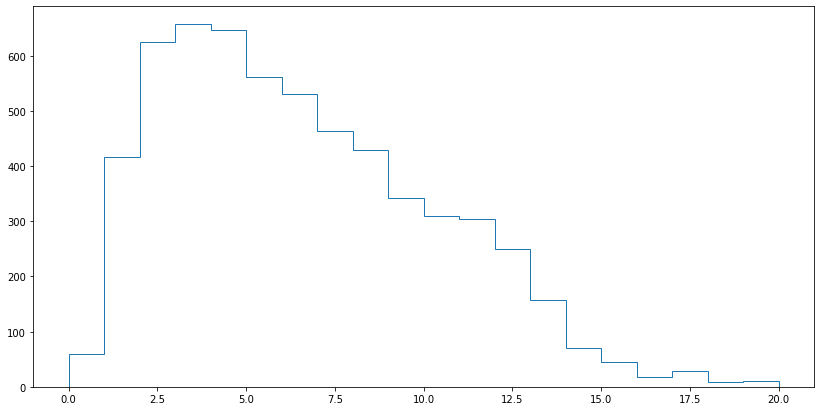

In [6]:
# dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec_rev1.fits.gz')
# dr16 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r12-l33.fits.gz')
apoafe = dr17['ALPHA_M']+dr17['M_H']-dr17['FE_H']
apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = dr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(dr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

k674 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.4.fits.gz')

# xmatch APOKASC with DR17
_, k674idx, dr17idx = np.intersect1d(k674['2MASS_ID'],dr17['APOGEE_ID'],return_indices=True)

k674 = k674[k674idx]
kdr17 = dr17[dr17idx]
salfeh = salfeh[dr17idx]
salfeh_err = salfeh_err[dr17idx]

# Select RGB stars
ageevs = np.where((k674['A3P_AGEMOD_JT']>-10.)&(k674['APOKASC3_CONS_EVSTATES']==1.0)&
                  (np.isfinite(kdr17['FE_H'])==True))

k674 = k674[ageevs]
kdr17 = kdr17[ageevs]
salfeh = salfeh[ageevs]
salfeh_err = salfeh_err[ageevs]

plt.figure(figsize=[14,7])
plt.hist(k674['A3P_AGEMOD_JT'],histtype='step',range=(0,20),bins=20)
plt.show()

# Gaia EDR3 Magnitude Errors

In [7]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

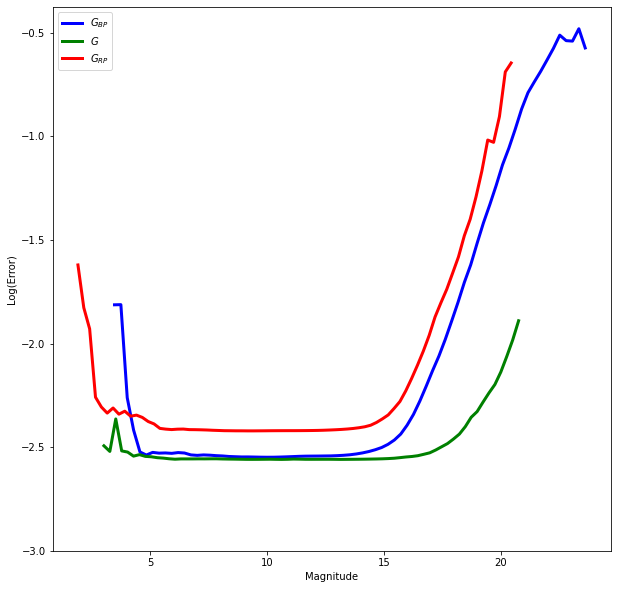

In [8]:
from scipy.stats import binned_statistic, binned_statistic_2d

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

bperrfunc = bspline(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = bspline(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = bspline(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(kdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

# Calculation

In [9]:
kasc_ext = 999999.0*np.ones((len(kdr17),6))
kasc_ext_err = 999999.0*np.ones((len(kdr17),6))
kasc_age = 999999.0*np.ones(len(kdr17))
kasc_chi = 999999.0*np.ones(len(kdr17))
kasc_rms = 999999.0*np.ones(len(kdr17))
kasc_mass = 999999.0*np.ones(len(kdr17))

for i in tqdm(range(len(kdr17))):
    
    # Initialize Aetas 
    te = np.array([kdr17['TEFF'][i],kdr17['TEFF_ERR'][i]])
    
    ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
                   [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    
    op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    kdr17['J'][i],kdr17['H'][i],kdr17['K'][i]],
                   [bperr[i],gerr[i],rperr[i],kdr17['J_ERR'][i],
                    kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
    
    di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

    CalcAge = Astrologium(te,ab,op,di,massive)
    
    exts = CalcAge.extinction()
    kasc_ext[i,:],kasc_ext_err[i,:] = exts[:,0],exts[:,1]
    kasc_age[i],kasc_chi[i],kasc_rms[i] = CalcAge.get_age()
    kasc_mass[i] = CalcAge.get_mass(kasc_age[i])

  0%|          | 0/6099 [00:00<?, ?it/s]

<ipython-input-3-571496dd4bc1>:420: RuntimeWarning: divide by zero encountered in log10
  lgage = np.log10(age*10**9)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-3-571496dd4bc1>:420: RuntimeWarning: invalid value encountered in log10
  lgage = np.log10(age*10**9)
<ipython-input-3-571496dd4bc1>:757: RuntimeWarning: divide by zero encountered in log10
  mass = bspl(np.log10(age*10**9))
<ipython-input-3-571496dd4bc1>:84: RuntimeWarning: invalid value encountered in log10
  self.distmod = 5.0*np.log10(distance)-5.0


In [66]:
parsec_age = 999999.0*np.ones(len(kdr17))
kasc_age_2 = 999999.0*np.ones(len(kdr17))

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mass_2_age_PARSEC(mass,salfeh,isochrones):
    '''
    Inputs:
    ------
        mass: star mass in Msun
        salfeh: Salaris corrected [Fe/H]
        isochrones: table of PARSEC isochrones
    
    Output:
    ------
        age: age in Gyr
    '''
    
    feh_lo,feh_hi = neighbors(isochrones['MH'],salfeh)
    
    iso_lo = isochrones[np.where(isochrones['MH']==feh_lo)]
    iso_hi = isochrones[np.where(isochrones['MH']==feh_hi)]
    
    try:
        # lower [Fe/H]
        sidx_lo = np.argsort(iso_lo['Mass'])
        smass_lo = iso_lo['Mass'][sidx_lo]
        _,uidx_lo = np.unique(smass_lo,return_index=True)
        smass_lo = smass_lo[uidx_lo]
        sage_lo = 10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9

        spl_lo = interp1d(smass_lo,sage_lo)

        # higher [Fe/H]
        sidx_hi = np.argsort(iso_hi['Mass'])
        smass_hi = iso_hi['Mass'][sidx_hi]
        _,uidx_hi = np.unique(smass_hi,return_index=True)
        smass_hi = smass_hi[uidx_hi]
        sage_hi = 10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9

        spl_hi = interp1d(smass_hi,sage_hi)

        # final spline
        final_spl = interp1d([feh_lo,feh_hi],[spl_lo(mass),spl_hi(mass)])
        age = final_spl(salfeh)
        return age
    except:
        return 999999.0

for i in tqdm(range(len(kdr17))):
    parsec_age[i] = mass_2_age_PARSEC(k674['APOKASC3P_MASS'][i],salfeh[i],massive)
    kasc_age_2[i] = mass_2_age_PARSEC(kasc_mass[i],salfeh[i],massive)

  0%|          | 0/6099 [00:00<?, ?it/s]

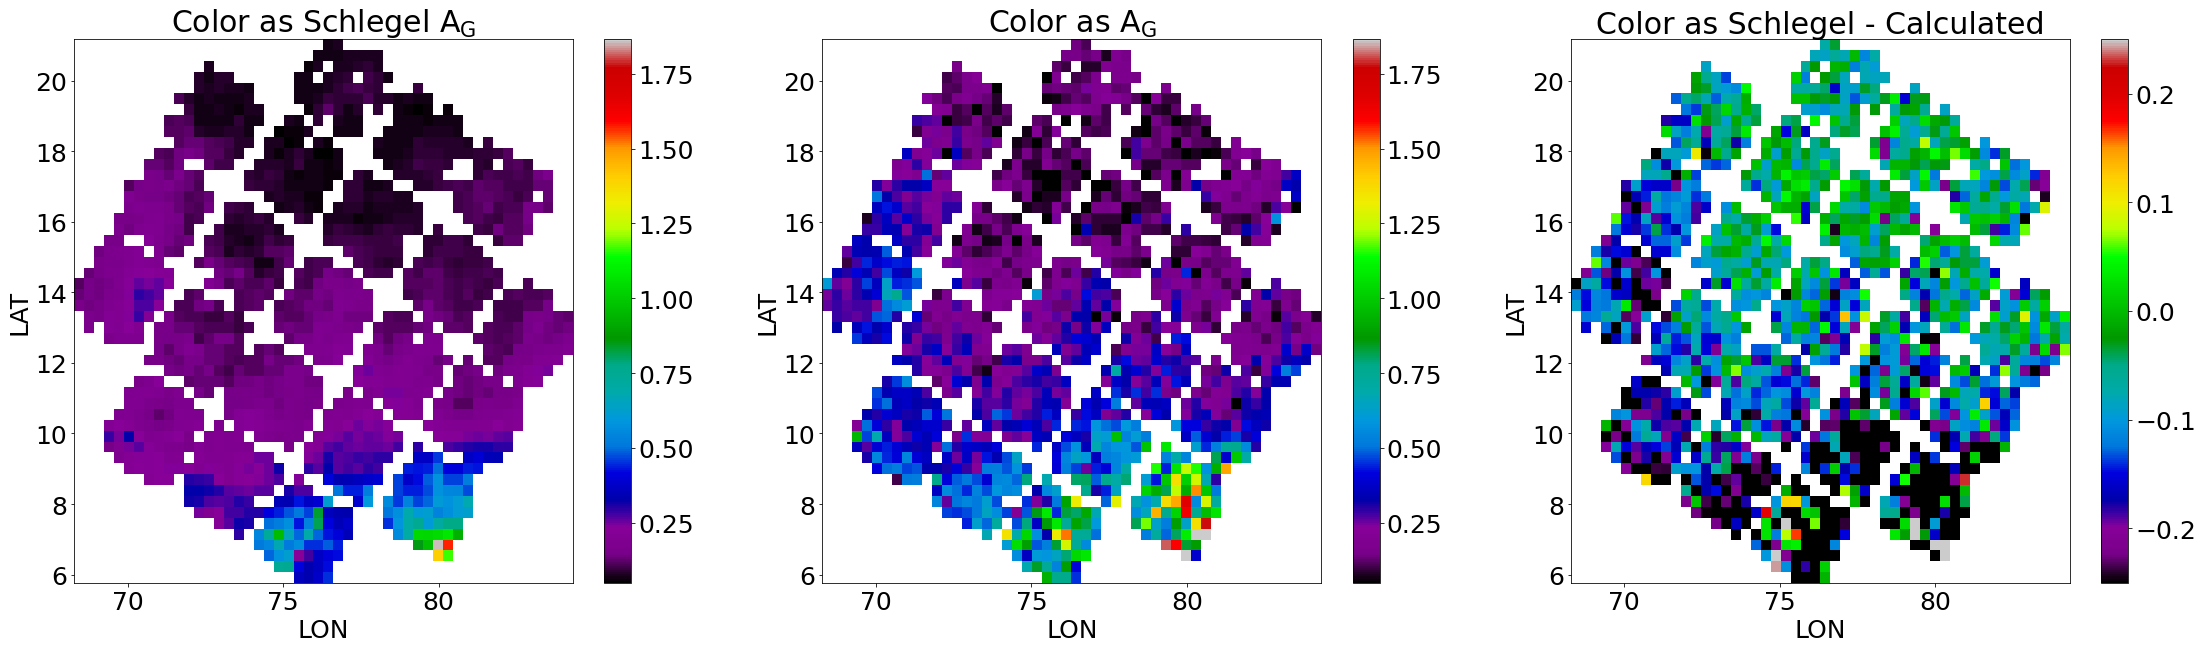

In [118]:
# matplotlib.rcParams.update({'font.size': 25})
# plt.figure(figsize=[38,10])
# plt.subplot(131)
# ext_fincut = np.where((np.isfinite(kdr17['SFD_EBV'])==True)&(kdr17['SFD_EBV']>0.))
# ext_ret = binned_statistic_2d(kdr17['GLON'][ext_fincut],kdr17['GLAT'][ext_fincut],
#                                   convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut],3.1),'median',bins=50)
# ext_ret.statistic[ext_ret.statistic == 0.0] = np.nan
# im = plt.imshow(ext_ret.statistic.T, origin='lower',
#                 extent=[ext_ret.x_edge[0],ext_ret.x_edge[-1],ext_ret.y_edge[0],ext_ret.y_edge[-1]],
#                 aspect='auto',interpolation='nearest',cmap='nipy_spectral',
#                 vmin=np.min(convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut],3.1)),
#                 vmax=np.max(convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut],3.1)))

# plt.colorbar()

# plt.title(r'Color as Schlegel ${\rm A_G}$')
# plt.xlabel(r'LON')
# plt.ylabel(r'LAT')

# ###
# plt.subplot(132)
# ext_fincut = np.where((np.isfinite(kasc_ext[:,0])==True)&(kasc_ext[:,0]<100.))
# ext_ret = binned_statistic_2d(kdr17['GLON'][ext_fincut],kdr17['GLAT'][ext_fincut],kasc_ext[:,0][ext_fincut],
#                               'median',bins=50)
# ext_ret.statistic[ext_ret.statistic == 0.0] = np.nan
# im = plt.imshow(ext_ret.statistic.T, origin='lower',
#                 extent=[ext_ret.x_edge[0],ext_ret.x_edge[-1],ext_ret.y_edge[0],ext_ret.y_edge[-1]],
#                 aspect='auto',interpolation='nearest',cmap='nipy_spectral',
#                 vmin=np.min(convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut],3.1)),
#                 vmax=np.max(convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut],3.1)))

# plt.colorbar()

# plt.title(r'Color as ${\rm A_G}$')
# plt.xlabel(r'LON')
# plt.ylabel(r'LAT')

# ###
# plt.subplot(133)
# ext_fincut = np.where((np.isfinite(kdr17['SFD_EBV'])==True)&(kdr17['SFD_EBV']>0.)&
#                       (np.isfinite(kasc_ext[:,0])==True)&(kasc_ext[:,0]<100.))
# ext_ret = binned_statistic_2d(kdr17['GLON'][ext_fincut],kdr17['GLAT'][ext_fincut],
#                                   convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut],3.1)-kasc_ext[:,0][ext_fincut],'median',
#                                   bins=50)
# ext_ret.statistic[ext_ret.statistic == 0.0] = np.nan
# im = plt.imshow(ext_ret.statistic.T, origin='lower',
#                 extent=[ext_ret.x_edge[0],ext_ret.x_edge[-1],ext_ret.y_edge[0],ext_ret.y_edge[-1]],
#                 aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=-0.25,vmax=0.25)

# plt.colorbar()

# plt.title(r'Color as Schlegel - Calculated')
# plt.xlabel(r'LON')
# plt.ylabel(r'LAT')

# # plt.suptitle(r'My Calibrated TEFF and LOGG')
# # plt.savefig('mycal_teff_logg_ext_map.pdf',bbox_inches='tight')
# plt.show()

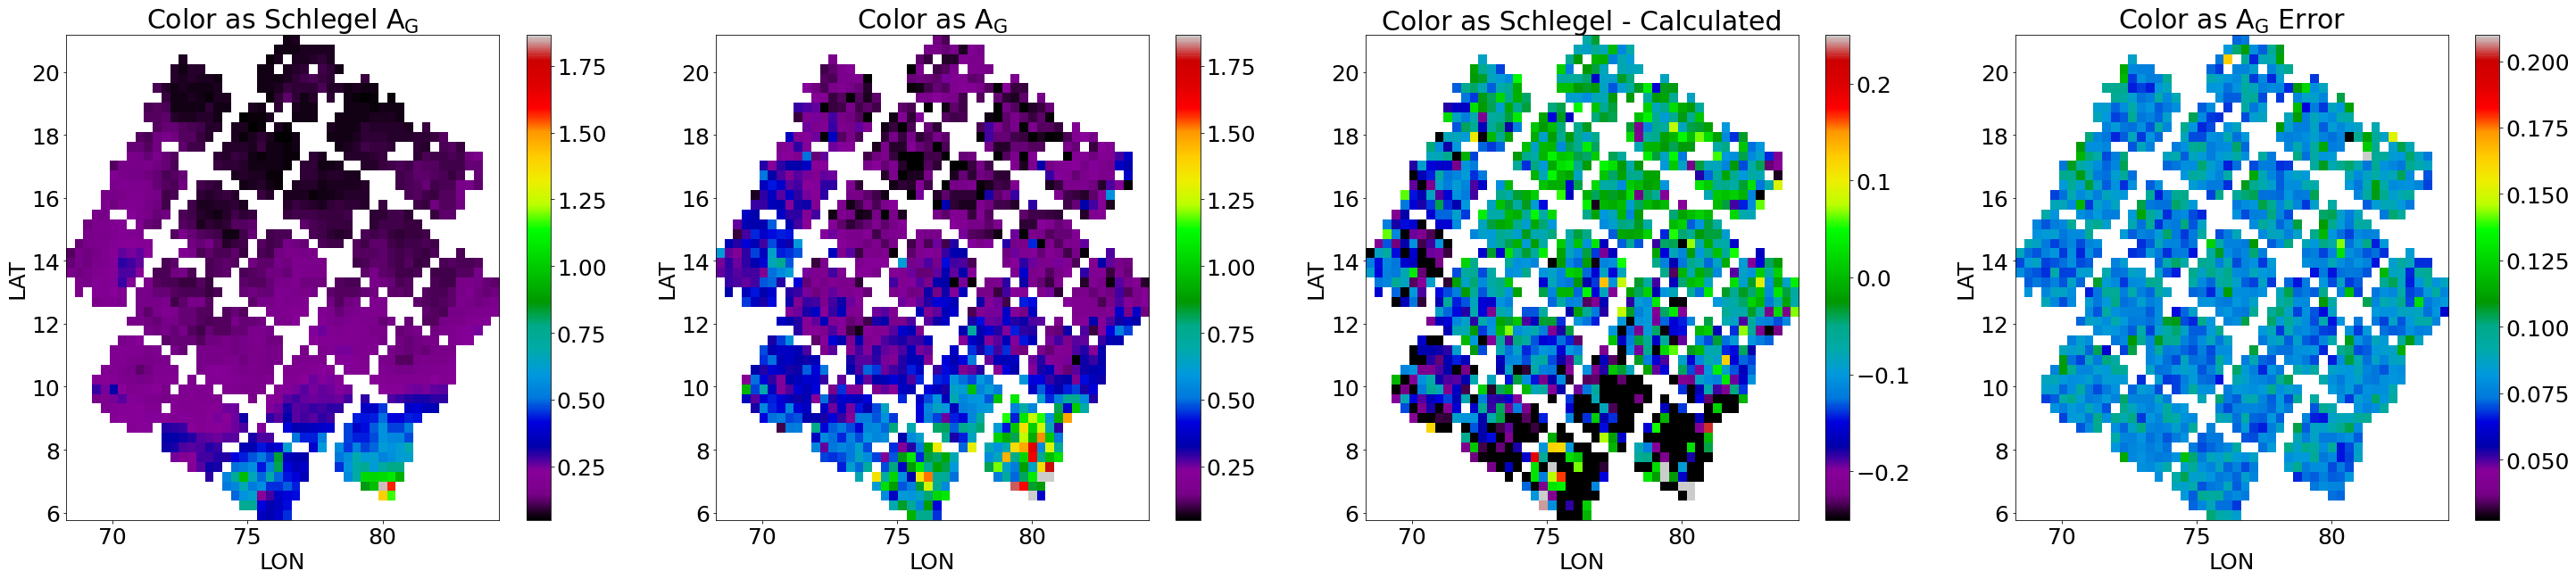

In [138]:
matplotlib.rcParams.update({'font.size': 25})
plt.figure(figsize=[50,10])
plt.subplot(141)
ext_fincut = np.where((np.isfinite(kdr17['SFD_EBV'])==True)&(kdr17['SFD_EBV']>0.))
ext_ret = binned_statistic_2d(kdr17['GLON'][ext_fincut],kdr17['GLAT'][ext_fincut],
                                  convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut],3.1),'median',bins=50)
ext_ret.statistic[ext_ret.statistic == 0.0] = np.nan
im = plt.imshow(ext_ret.statistic.T, origin='lower',
                extent=[ext_ret.x_edge[0],ext_ret.x_edge[-1],ext_ret.y_edge[0],ext_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',
                vmin=np.min(convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut],3.1)),
                vmax=np.max(convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut],3.1)))

plt.colorbar()

plt.title(r'Color as Schlegel ${\rm A_G}$')
plt.xlabel(r'LON')
plt.ylabel(r'LAT')

###
plt.subplot(142)
ext_fincut = np.where((np.isfinite(kasc_ext[:,0])==True)&(kasc_ext[:,0]<100.))
ext_ret = binned_statistic_2d(kdr17['GLON'][ext_fincut],kdr17['GLAT'][ext_fincut],kasc_ext[:,0][ext_fincut],
                              'median',bins=50)
ext_ret.statistic[ext_ret.statistic == 0.0] = np.nan
im = plt.imshow(ext_ret.statistic.T, origin='lower',
                extent=[ext_ret.x_edge[0],ext_ret.x_edge[-1],ext_ret.y_edge[0],ext_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',
                vmin=np.min(convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut],3.1)),
                vmax=np.max(convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut],3.1)))

plt.colorbar()

plt.title(r'Color as ${\rm A_G}$')
plt.xlabel(r'LON')
plt.ylabel(r'LAT')

###
plt.subplot(143)
ext_fincut = np.where((np.isfinite(kdr17['SFD_EBV'])==True)&(kdr17['SFD_EBV']>0.)&
                      (np.isfinite(kasc_ext[:,0])==True)&(kasc_ext[:,0]<100.))
ext_ret = binned_statistic_2d(kdr17['GLON'][ext_fincut],kdr17['GLAT'][ext_fincut],
                                  convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut],3.1)-kasc_ext[:,0][ext_fincut],'median',
                                  bins=50)
ext_ret.statistic[ext_ret.statistic == 0.0] = np.nan
im = plt.imshow(ext_ret.statistic.T, origin='lower',
                extent=[ext_ret.x_edge[0],ext_ret.x_edge[-1],ext_ret.y_edge[0],ext_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=-0.25,vmax=0.25)

plt.colorbar()

plt.title(r'Color as Schlegel - Calculated')
plt.xlabel(r'LON')
plt.ylabel(r'LAT')

###
plt.subplot(144)
ext_fincut = np.where((np.isfinite(kasc_ext_err[:,0])==True)&(kasc_ext_err[:,0]<100.))
ext_ret = binned_statistic_2d(kdr17['GLON'][ext_fincut],kdr17['GLAT'][ext_fincut],kasc_ext_err[:,0][ext_fincut],
                              'median',bins=50)
ext_ret.statistic[ext_ret.statistic == 0.0] = np.nan
im = plt.imshow(ext_ret.statistic.T, origin='lower',
                extent=[ext_ret.x_edge[0],ext_ret.x_edge[-1],ext_ret.y_edge[0],ext_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral')

plt.colorbar()

plt.title(r'Color as ${\rm A_G}$ Error')
plt.xlabel(r'LON')
plt.ylabel(r'LAT')

# plt.suptitle(r'My Calibrated TEFF and LOGG')
# plt.savefig('mycal_teff_logg_ext_map.pdf',bbox_inches='tight')
plt.show()

(0.0, 5.0)

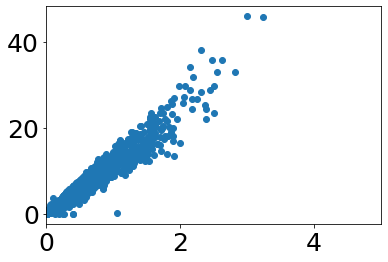

In [68]:
plt.scatter(kasc_ext[:,0],kasc_ext[:,0]/kasc_ext_err[:,0])
plt.xlim(-0,5)
# plt.ylim(-2,2)

(0.0, 0.25)

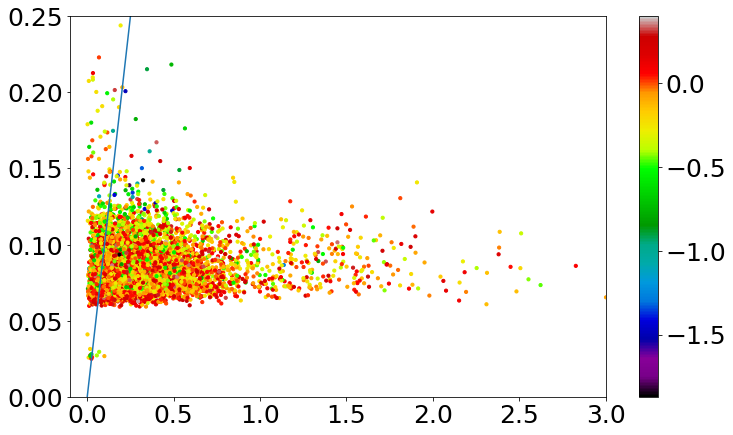

In [69]:
plt.figure(figsize=[12,7])
plt.scatter(kasc_ext[:,0],kasc_ext_err[:,0],c=kdr17['FE_H'],cmap='nipy_spectral',s=10)
plt.plot([0,3],[0,3])
plt.colorbar()
plt.xlim(-0.1,3.)
plt.ylim(0,0.25)

0.07956293197511702


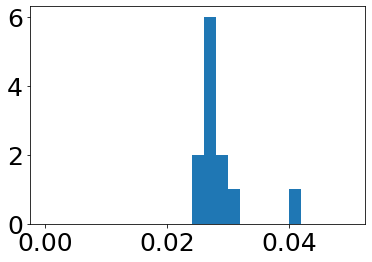

In [70]:
plt.hist(kasc_ext_err[:,0],range=(0,0.05),bins=25)
# print(np.nanmedian(kasc_ext[:,0]))
print(np.nanmedian(kasc_ext_err[:,0]))

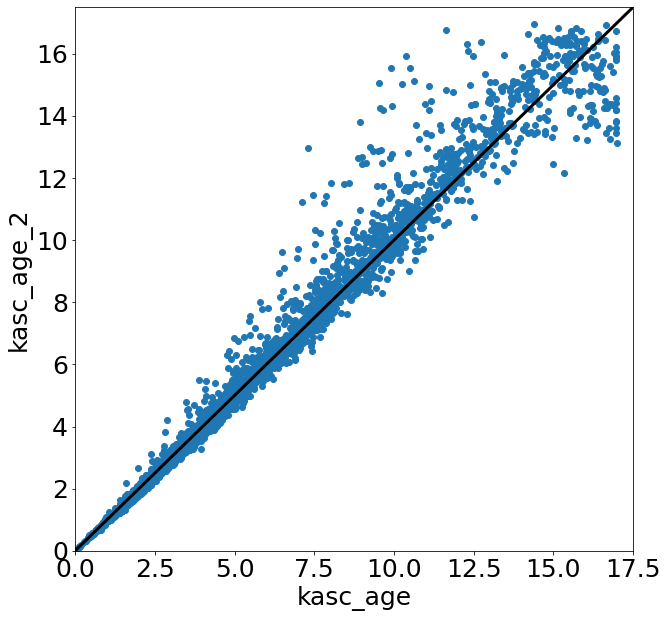

In [97]:
plt.figure(figsize=[10,10])
plt.scatter(kasc_age,kasc_age_2)
plt.plot([0,20],[0,20],c='k',lw=3.0)
plt.xlim(0,17.5)
plt.ylim(0,17.5)

plt.xlabel(r'kasc_age')
plt.ylabel(r'kasc_age_2')
plt.show()

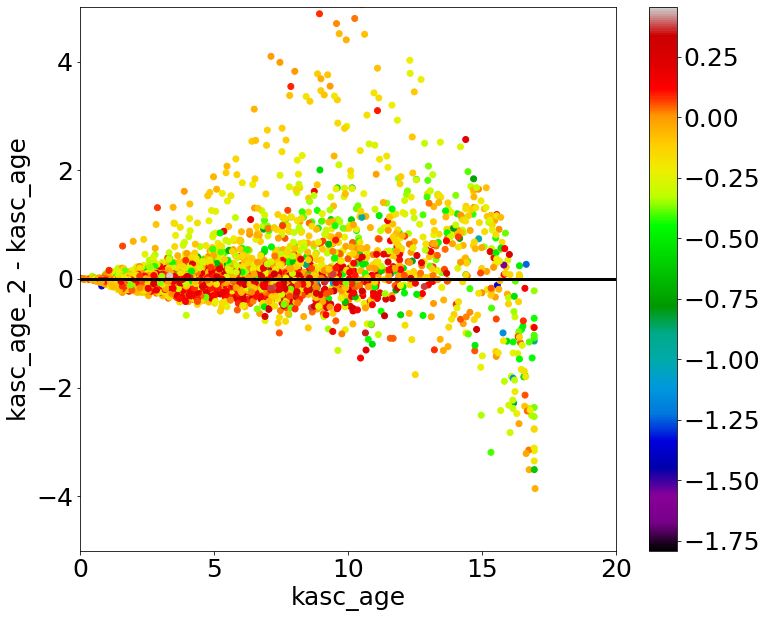

In [94]:
plt.figure(figsize=[12,10])
plt.scatter(kasc_age,kasc_age_2-kasc_age,c=salfeh,cmap='nipy_spectral')
plt.colorbar()
plt.axhline(0.0,c='k',lw=3.0)
plt.xlim(0,20)
plt.ylim(-5,5)

plt.xlabel(r'kasc_age')
plt.ylabel(r'kasc_age_2 - kasc_age')
plt.show()

(array([  13.,   11.,   37.,   89., 2492., 2240.,  243.,  107.,   63.,
          18.]),
 array([-2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 <BarContainer object of 10 artists>)

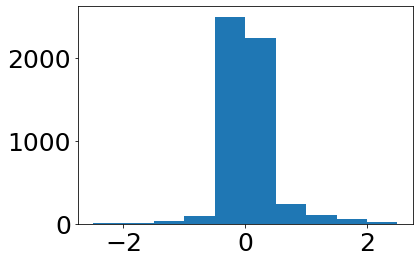

In [134]:
plt.hist(kasc_age_2-kasc_age,range=(-2.5,2.5))

In [71]:
np.where(np.isfinite(kasc_ext_err[:,0])==False)

(array([ 221,  517,  631,  711, 1651, 2003, 2137, 2694, 3657, 3755, 3833,
        4083, 4183, 4452, 4977, 5340, 5377, 5472, 6062]),)

In [72]:
np.where(np.isfinite(kasc_ext[:,0])==False)

(array([], dtype=int64),)

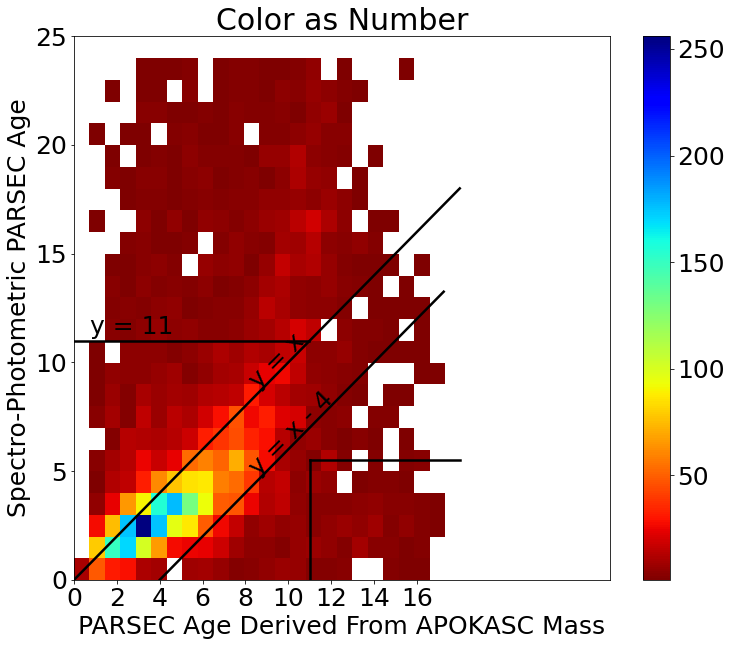

In [73]:
plt.figure(figsize=[12,10])
xmax = 18
ymax = 25
nbins = 25

age2age_fincut = np.where((np.isfinite(kasc_age)==True)&(kasc_age<100.)&
                         (np.isfinite(parsec_age)==True)&
                         (parsec_age<100.))

age2age_ret = binned_statistic_2d(parsec_age,kasc_age,
                                  parsec_age,'count',
                                  bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/nbins)])

age2age_ret.statistic[age2age_ret.statistic == 0.0] = np.nan

im = plt.imshow(age2age_ret.statistic.T, origin='lower',
                extent=[age2age_ret.x_edge[0],age2age_ret.x_edge[-1],
                        age2age_ret.y_edge[0],age2age_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='jet_r')

plt.colorbar()

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')


plt.xlim(0,25)#17.25)
plt.ylim(0,25)#17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.title(r'Color as Number')
plt.xlabel(r'PARSEC Age Derived From APOKASC Mass')
plt.ylabel(r'Spectro-Photometric PARSEC Age')

plt.show()

(array([3533., 1346.,  458.,  315.,  144.,   95.,   53.,   45.,   24.,
          23.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 10 artists>)

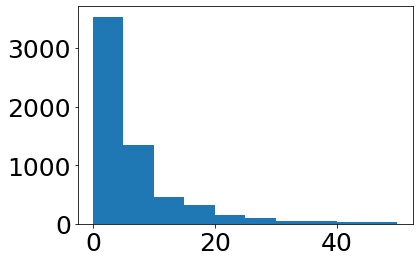

In [74]:
plt.hist(kasc_age,range=(0,50))

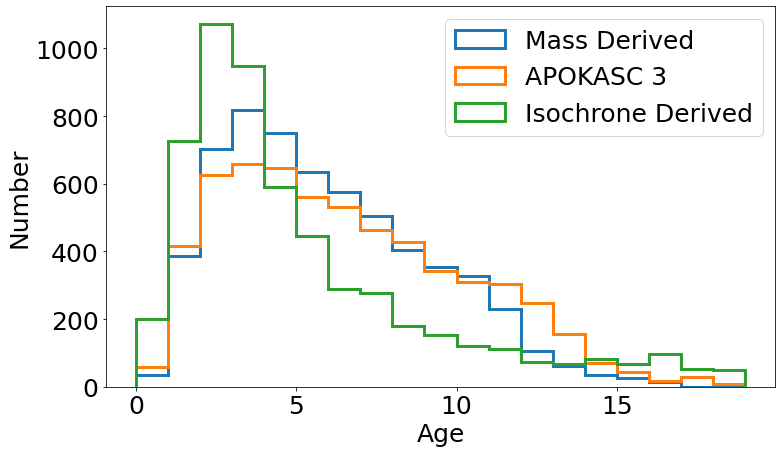

In [75]:
plt.figure(figsize=[12,7])
plt.hist(parsec_age,range(0,20),histtype='step',lw=3.0,label='Mass Derived')
plt.hist(k674['A3P_AGEMOD_JT'],range(0,20),histtype='step',lw=3.0,label='APOKASC 3')
plt.hist(kasc_age,range(0,20),histtype='step',lw=3.0,label='Isochrone Derived')
plt.legend()
plt.xlabel(r'Age')
plt.ylabel(r'Number')
plt.show()

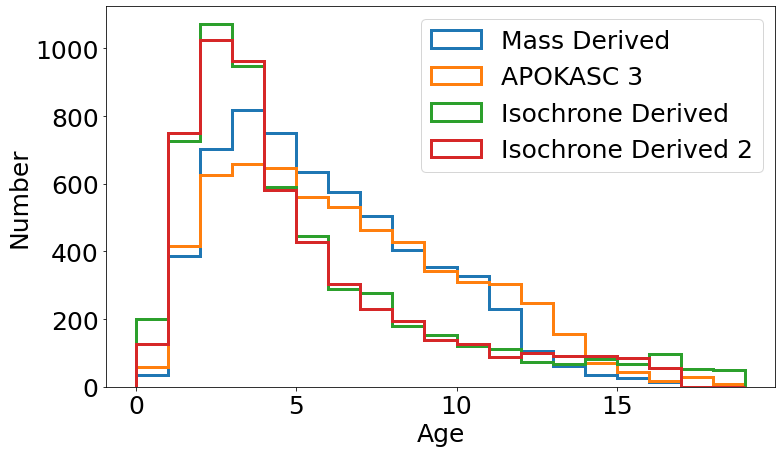

In [95]:
plt.figure(figsize=[12,7])
plt.hist(parsec_age,range(0,20),histtype='step',lw=3.0,label='Mass Derived')
plt.hist(k674['A3P_AGEMOD_JT'],range(0,20),histtype='step',lw=3.0,label='APOKASC 3')
plt.hist(kasc_age,range(0,20),histtype='step',lw=3.0,label='Isochrone Derived')
plt.hist(kasc_age_2,range(0,20),histtype='step',lw=3.0,label='Isochrone Derived 2')
plt.legend()
plt.xlabel(r'Age')
plt.ylabel(r'Number')
plt.show()

(array([ 665., 1745., 1103.,  610.,  397.,  252.,  173.,  157.,  158.,
         117.]),
 array([ 0.06415088,  1.75367553,  3.44320017,  5.13272481,  6.82224946,
         8.5117741 , 10.20129875, 11.89082339, 13.58034804, 15.26987268,
        16.95939732]),
 [<matplotlib.patches.Polygon at 0x7f81b531a850>])

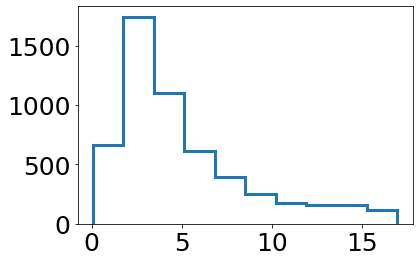

In [123]:
plt.hist(kasc_age_2[np.where(kasc_age_2<100.)],histtype='step',lw=3.0)

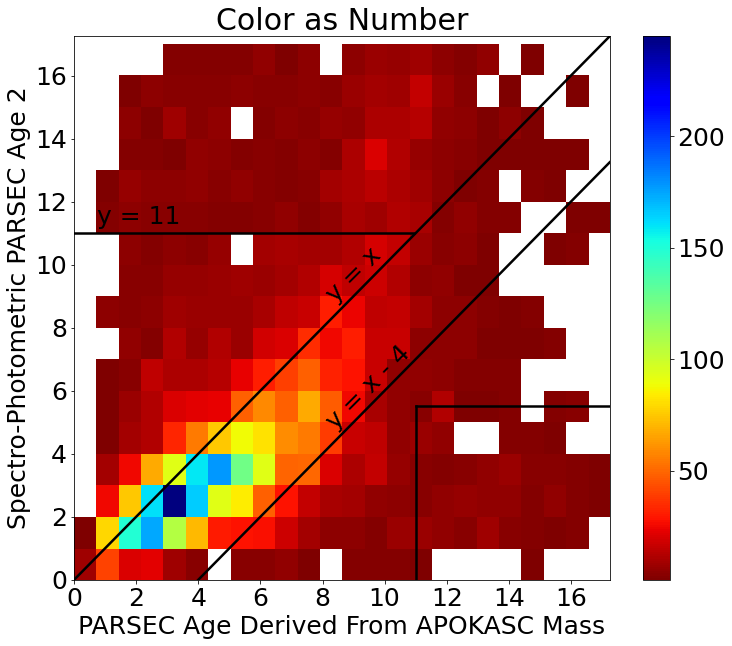

In [128]:
plt.figure(figsize=[12,10])
xmax = 18
ymax = 25
nbins = 25

age2age2_fincut = np.where((np.isfinite(kasc_age_2)==True)&(kasc_age_2<100.)&
                         (np.isfinite(parsec_age)==True)&
                         (parsec_age<100.))

age2age2_ret = binned_statistic_2d(parsec_age,kasc_age_2,
                                  parsec_age,'count',
                                  bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/nbins)])

age2age2_ret.statistic[age2age2_ret.statistic == 0.0] = np.nan

im = plt.imshow(age2age2_ret.statistic.T, origin='lower',
                extent=[age2age2_ret.x_edge[0],age2age2_ret.x_edge[-1],
                        age2age2_ret.y_edge[0],age2age2_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='jet_r')

plt.colorbar()

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')


plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.title(r'Color as Number')
plt.xlabel(r'PARSEC Age Derived From APOKASC Mass')
plt.ylabel(r'Spectro-Photometric PARSEC Age 2')

plt.show()

In [125]:
len(np.squeeze(np.where(kasc_age_2>100.)))

46

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
        71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
        88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 [<matplotlib.patches.Polygon at 0x7f81b5ab5cd0>])

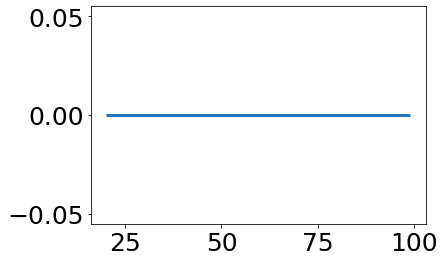

In [129]:
plt.hist(kasc_age_2,range(20,100),histtype='step',lw=3.0,label='Isochrone Derived')

(array([33., 35., 32., 21., 23., 16., 19., 26., 19., 15., 20., 10.,  9.,
         8.,  6.,  7., 10.,  8., 11.,  9., 11.,  2.,  5.,  1.,  5.,  5.,
         4.,  3.,  7.,  4.,  1.,  5.,  2.,  2.,  2.,  0.,  4.,  3.,  0.,
         2.,  2.,  0.,  2.,  0.,  2.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,
         1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  2.,  0.,
         2.]),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
        71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
        88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 [<matplotlib.patches.Polygon at 0x7f81c2c3edf0>])

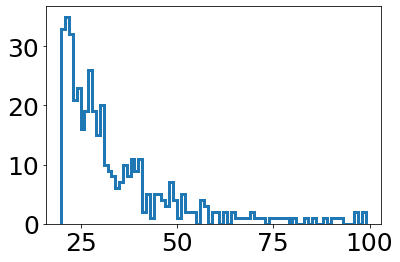

In [76]:
plt.hist(kasc_age,range(20,100),histtype='step',lw=3.0,label='Isochrone Derived')

In [77]:
print(len(np.squeeze(np.where((kasc_age>20)&(kasc_age<100)))))

436


(array([17., 10.,  9.,  3., 11.,  7., 10.,  5.,  4.,  7.,  7.,  3.,  4.,
         5.,  2.,  5.,  2.,  5.,  2.,  0.,  1.,  3.,  3.,  4.,  1.,  1.,
         4.,  1.,  3.,  0.,  2.,  2.,  0.,  0.,  2.,  2.,  2.,  0.,  0.,
         1.,  0.,  2.,  0.,  2.,  1.,  1.,  0.,  1.,  1.,  2.,  0.,  0.,
         1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
        71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
        88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 [<matplotlib.patches.Polygon at 0x7f81c2de6100>])

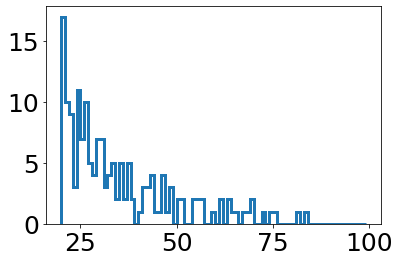

In [78]:
plt.hist(k674['A3P_AGEMOD_JT'],range(20,100),histtype='step',lw=3.0,label='APOKASC 3')

In [79]:
print(len(np.squeeze(np.where((k674['A3P_AGEMOD_JT']>20)&(k674['A3P_AGEMOD_JT']<100)))))

165


In [111]:
oldest_ap3 = np.where((k674['A3P_AGEMOD_JT']>20)&(k674['A3P_AGEMOD_JT']<100))
oldest_ksc = np.where((kasc_age>20)&(kasc_age<100))

In [130]:
max(k674['A3P_AGEMOD_JT'])

83.433

In [80]:
(465-165)/165

1.8181818181818181

(array([33., 35., 32., 21., 23., 16., 19., 26., 19., 15., 20., 10.,  9.,
         8.,  6.,  7., 10.,  8., 11.,  9., 11.,  2.,  5.,  1.,  5.,  5.,
         4.,  3.,  7.,  4.,  1.,  5.,  2.,  2.,  2.,  0.,  4.,  3.,  0.,
         2.,  2.,  0.,  2.,  0.,  2.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,
         1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  2.,  0.,
         2.]),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
        71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
        88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 [<matplotlib.patches.Polygon at 0x7f81bdf1eee0>])

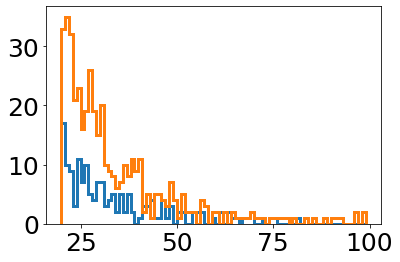

In [101]:
plt.hist(k674['A3P_AGEMOD_JT'],range(20,100),histtype='step',lw=3.0,label='APOKASC 3')
plt.hist(kasc_age,range(20,100),histtype='step',lw=3.0,label='Isochrone Derived')

In [82]:
singage = massive[np.where(massive['logAge'] == closest(massive['logAge'],np.log10(17*10**9)))]

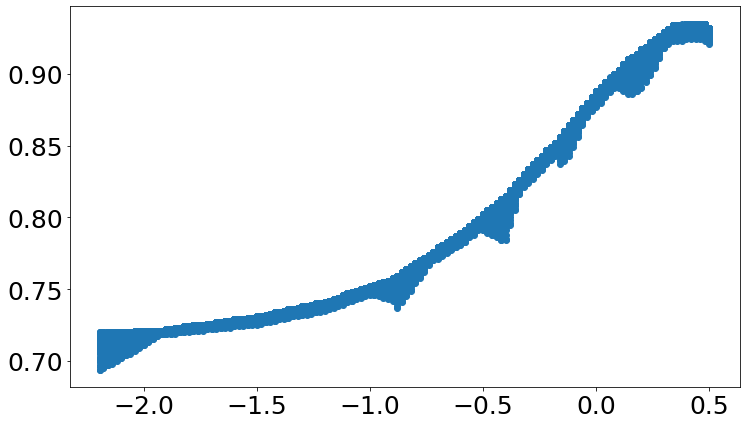

In [45]:
plt.figure(figsize=[12,7])
plt.scatter(singage['MH'],singage['Mass'])

In [139]:
plt.figure(figsize=[12,7])
plt.scatter(10**massive['logAge']/10**9,massive['Mass'],c=massive['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.ylim(top=4)
plt.ylabel(r'Mass')
plt.xlabel(r'Age')
plt.show()

KeyboardInterrupt: 

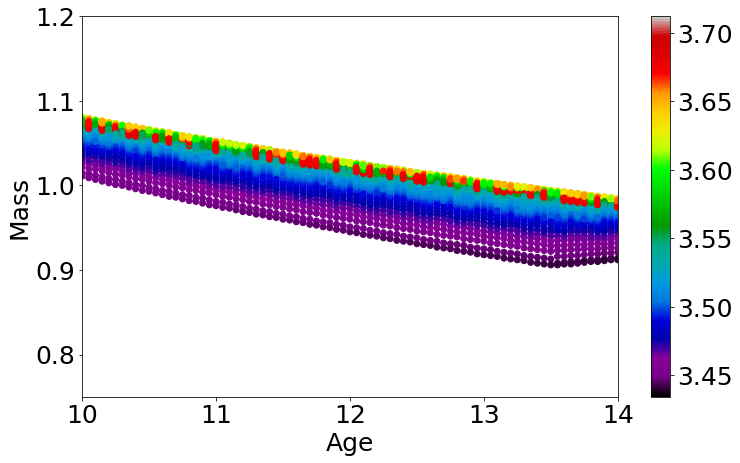

In [150]:
mmr = np.where(massive['MH']==np.max(massive['MH']))
mmp = np.where(massive['MH']==np.min(massive['MH']))

plt.figure(figsize=[12,7])
plt.scatter(10**massive['logAge'][mmr]/10**9,massive['Mass'][mmr],c=massive['logTe'][mmr],cmap='nipy_spectral')

plt.colorbar()
# plt.scatter(10**massive['logAge'][mmp]/10**9,massive['Mass'][mmp])

# plt.axhline(2.0)
# plt.axhline(1.5,c='tab:orange')

# plt.axhline(0.95)
# plt.axhline(0.7,c='tab:orange')

plt.ylim(0.75,1.2)
plt.xlim(10,14)
plt.xlabel(r'Age')
plt.ylabel(r'Mass')
plt.show()

In [ ]:
for age and teff single mass

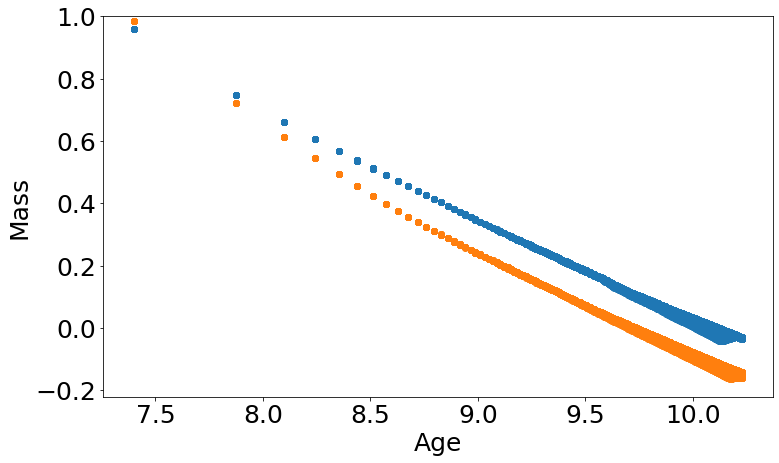

In [108]:
plt.figure(figsize=[12,7])
plt.scatter(massive['logAge'][mmr],np.log10(massive['Mass'][mmr]))
plt.scatter(massive['logAge'][mmp],np.log10(massive['Mass'][mmp]))

plt.ylim(top=1)
plt.xlabel(r'Age')
plt.ylabel(r'Mass')
plt.show()

In [61]:
print(len(np.squeeze(np.where(k674['A3P_AGEMOD_JT']<0))))

0


In [62]:
max(k674['A3P_AGEMOD_JT'])

83.433

In [63]:
print(len(np.squeeze(np.where(kasc_age>20))))

447


In [64]:
print(len(np.squeeze(np.where(k674['A3P_AGEMOD_JT']>20))))

165


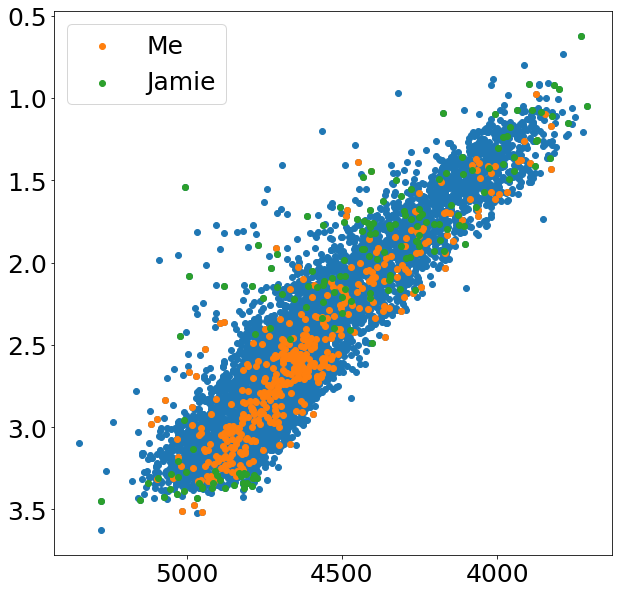

In [113]:
plt.figure(figsize=[10,10])
plt.scatter(kdr17['TEFF'],kdr17['LOGG'])
plt.scatter(kdr17['TEFF'][oldest_ksc],kdr17['LOGG'][oldest_ksc],label='Me')
plt.scatter(kdr17['TEFF'][oldest_ap3],kdr17['LOGG'][oldest_ap3],label='Jamie')
plt.legend()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

(array([ 3.,  4.,  6.,  5.,  5.,  4.,  7.,  9., 10., 11., 10., 16., 10.,
         9.,  4.,  5.,  5., 13.,  4.,  7.,  8.,  6.,  2.,  1.,  1.]),
 array([3711.9727, 3774.5103, 3837.0479, 3899.5852, 3962.1228, 4024.6604,
        4087.198 , 4149.7354, 4212.273 , 4274.8105, 4337.348 , 4399.8857,
        4462.4233, 4524.9604, 4587.498 , 4650.0356, 4712.573 , 4775.111 ,
        4837.6484, 4900.186 , 4962.7236, 5025.2607, 5087.7983, 5150.336 ,
        5212.8735, 5275.411 ], dtype=float32),
 [<matplotlib.patches.Polygon at 0x7f81bc418a90>])

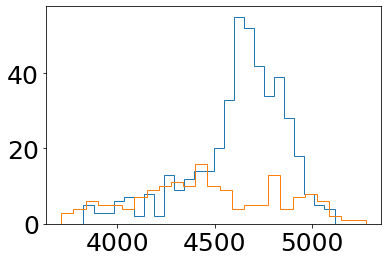

In [116]:
plt.hist(kdr17['TEFF'][oldest_ksc],histtype='step',bins=25)
plt.hist(kdr17['TEFF'][oldest_ap3],histtype='step',bins=25)

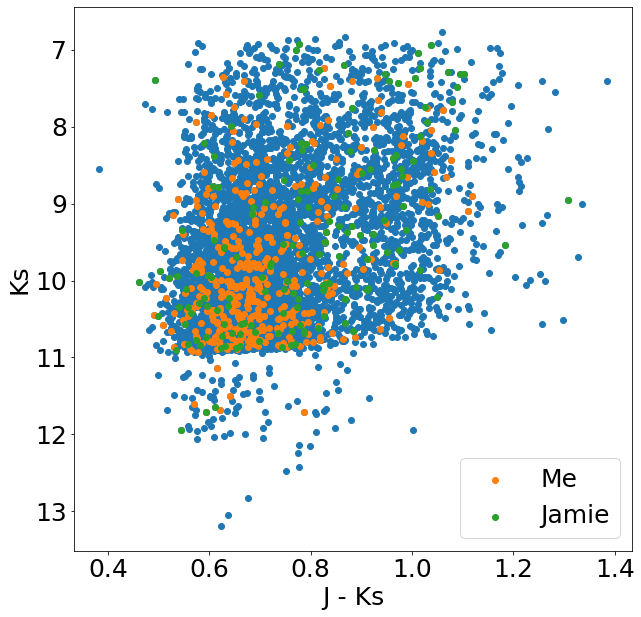

In [121]:
plt.figure(figsize=[10,10])
plt.scatter(kdr17['J']-kdr17['K'],kdr17['K'])
plt.scatter((kdr17['J']-kdr17['K'])[oldest_ksc],kdr17['K'][oldest_ksc],label='Me')
plt.scatter((kdr17['J']-kdr17['K'])[oldest_ap3],kdr17['K'][oldest_ap3],label='Jamie')
plt.legend()
plt.gca().invert_yaxis()

plt.xlabel(r'J - Ks')
plt.ylabel(r'Ks')
plt.show()